In [41]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [42]:
df=pd.read_parquet("ori_df.parquet")
df.columns

Index(['Tail_Number', 'prev_arr_dt', 'prev_arr_delay', 'prev_origin',
       'prev_dest', 'prev_crs_dep', 'prev_crs_arr', 'next_dep_dt', 'DepDelay',
       'next_origin', 'Dest', 'next_crs_dep', 'next_crs_arr', 'turn_time_min',
       'O-D', 'historical_turn_time_min_3mean', 'scheduled_turn_time',
       'realized slack', 'scheturn_bucket', 'prev_bin', 'op_carrier',
       'op_flight', 'Origin', 'carrier_slope', 'origin_slope', 'crsdep_hour',
       'dep_hour', 'prev_arr_hour', 'datetime', 'temperature_2m',
       'wind_speed_10m', 'wind_gusts_10m', 'precipitation', 'is_day',
       'cloud_cover', 'airport', 'datetime_pa', 'temperature_2m_pa',
       'wind_speed_10m_pa', 'wind_gusts_10m_pa', 'precipitation_pa',
       'is_day_pa', 'cloud_cover_pa', 'airport_pa', 'Distance',
       'DistanceGroup', 'CRSElapsedTime', 'DayOfWeek', 'dep_dt', 'FlightDate',
       'crsdep_tbin', 'prev_arr_tbin'],
      dtype='object')

In [43]:
y_label= "DepDelay"

numeric_cols = [
'prev_arr_delay',
 'historical_turn_time_min_3mean',
 'scheduled_turn_time',
 'realized slack',
 'carrier_slope',
 'origin_slope',
 'temperature_2m',
 'wind_speed_10m',
 'wind_gusts_10m',
 'precipitation',
 'cloud_cover',
 'temperature_2m_pa',
 'wind_speed_10m_pa',
 'wind_gusts_10m_pa',
 'precipitation_pa',
 'cloud_cover_pa',
 'Distance',
 'CRSElapsedTime',
]

cat_cols=[
 'prev_origin',
#  'prev_crs_arr',
 'Dest',
 'scheturn_bucket',
 'prev_bin',
 'op_carrier',
 'Origin',
#  'crsdep_hour',
 'prev_arr_tbin',
 'crsdep_tbin',
 'is_day',
'is_day_pa',
'DistanceGroup',
 'DayOfWeek']



Features Engineering:

In [ ]:
import numpy as np
import pandas as pd

def add_advanced_features(df):
    df = df.copy()
    df["FlightDate"] = pd.to_datetime(df["FlightDate"])
    df = df.sort_values("FlightDate")


    df["slack_time"] = df["scheduled_turn_time"] - df["historical_turn_time_min_3mean"]

    df["prev_arr_delay_clip"] = df["prev_arr_delay"].clip(lower=-30, upper=180)

    df["scheduled_turn_capped"] = df["scheduled_turn_time"].clip(lower=5, upper=180)

    df["prop_prev_delay_over_planned_turn"] = (
        df["prev_arr_delay_clip"] / df["scheduled_turn_capped"]
    )

    df["prop_prev_delay_over_turn"] = df["prev_arr_delay_clip"] / (df["scheduled_turn_time"] + 1e-3)

    df["short_turn"] = (df["scheduled_turn_time"] < 45).astype(int)
    df["short_turn_prev_delay"] = df["short_turn"] * df["prev_arr_delay_clip"]


    df["wind_speed_diff"] = df["wind_speed_10m"] - df["wind_speed_10m_pa"]
    df["wind_gusts_diff"] = df["wind_gusts_10m"] - df["wind_gusts_10m_pa"]
    df["temp_diff"]       = df["temperature_2m"] - df["temperature_2m_pa"]
    df["precip_diff"]     = df["precipitation"] - df["precipitation_pa"]
    df["cloud_diff"]      = df["cloud_cover"] - df["cloud_cover_pa"]

    df["has_rain"]    = (df["precipitation"] > 0.1).astype(int)
    df["has_rain_pa"] = (df["precipitation_pa"] > 0.1).astype(int)


    df = df.sort_values(["Origin", "FlightDate"])
    df["origin_delay_mean_7d"] = (
        df.groupby("Origin")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=3).mean())
    )

    df = df.sort_values(["op_carrier", "FlightDate"])
    df["carrier_delay_mean_7d"] = (
        df.groupby("op_carrier")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=3).mean())
    )

    df["Route"] = df["Origin"].astype(str) + "_" + df["Dest"].astype(str)
    df = df.sort_values(["Route", "FlightDate"])
    df["route_delay_mean_7d"] = (
        df.groupby("Route")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=5).mean())
    )

    global_mean_delay = df["DepDelay"].mean()
    for col in ["origin_delay_mean_7d", "carrier_delay_mean_7d", "route_delay_mean_7d"]:
        df[col] = df[col].fillna(global_mean_delay)


    df["avg_speed"] = df["Distance"] / (df["CRSElapsedTime"] + 1e-3)
    df["prev_big_delay"] = (df["prev_arr_delay"] >= 30).astype(int)

    return df


In [ ]:
df = add_advanced_features(df)


advanced_numeric = [
    "slack_time",
    "prev_arr_delay_clip",
    "prop_prev_delay_over_turn",
    "short_turn_prev_delay",
    "wind_speed_diff",
    "wind_gusts_diff",
    "temp_diff",
    "precip_diff",
    "cloud_diff",
    "origin_delay_mean_7d",
    "carrier_delay_mean_7d",
    "route_delay_mean_7d",
    "avg_speed",
]


advanced_cat = [
    "short_turn",      
    "has_rain",
    "has_rain_pa",
    # "Route",
    "prev_big_delay",
]

numeric_cols_extended = numeric_cols + advanced_numeric
cat_cols_extended     = cat_cols + advanced_cat

features_extended = numeric_cols_extended + cat_cols_extended


In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


y_label = "DepDelay"

df_model = df.copy()
df_model = df_model[df_model[y_label].notna()].copy()#make sure y not nan
df_model["FlightDate"] = pd.to_datetime(df_model["FlightDate"])
df_model = df_model.sort_values("FlightDate")


train_end = "2025-01-21"
valid_end = "2025-01-28"

train = df_model[df_model["FlightDate"] <= train_end]
valid = df_model[(df_model["FlightDate"] > train_end) & (df_model["FlightDate"] <= valid_end)]
test  = df_model[df_model["FlightDate"] > valid_end]

X_train_raw, y_train = train[features_extended], train[y_label]
X_valid_raw, y_valid = valid[features_extended], valid[y_label]
X_test_raw,  y_test  = test[features_extended],  test[y_label]

print("Train:", X_train_raw.shape, "Valid:", X_valid_raw.shape, "Test:", X_test_raw.shape)

def eval_regression(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MAE : {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²  : {r2:.3f}")
    return mae, rmse, r2


Train: (287832, 47) Valid: (96362, 47) Test: (42071, 47)


Features processing:

In [48]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_train_num = num_pipeline.fit_transform(X_train_raw[numeric_cols_extended])
X_valid_num = num_pipeline.transform(X_valid_raw[numeric_cols_extended])
X_test_num  = num_pipeline.transform(X_test_raw[numeric_cols_extended])


In [ ]:

cat_col_maps = {}
for col in cat_cols_extended:

    all_cats = pd.Series(
        df_model[col]
        .astype(str)
        .fillna("__MISSING__")
        .unique()
    )

    cat_to_idx = {cat: i + 1 for i, cat in enumerate(all_cats)}
    cat_col_maps[col] = cat_to_idx

def cats_to_indices(df_part, cat_cols, cat_maps):
    idx_df = {}
    for col in cat_cols:
        mapping = cat_maps[col]
        idx = (
            df_part[col]
            .astype(str)
            .fillna("__MISSING__")
            .map(mapping)
            .fillna(0)        
            .astype("int64")
        )
        idx_df[col] = idx.values

    return np.vstack([idx_df[c] for c in cat_cols]).T

X_train_cat_idx = cats_to_indices(X_train_raw, cat_cols_extended, cat_col_maps)
X_valid_cat_idx = cats_to_indices(X_valid_raw, cat_cols_extended, cat_col_maps)
X_test_cat_idx  = cats_to_indices(X_test_raw,  cat_cols_extended, cat_col_maps)


In [50]:
X_train_cat_idx.shape

(287832, 16)

In [51]:
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print("Using device:", device)

class FlightDelayDataset(Dataset):
    def __init__(self, X_num, X_cat_idx, y):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat_idx, dtype=torch.long)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

train_ds = FlightDelayDataset(X_train_num, X_train_cat_idx, y_train)
valid_ds = FlightDelayDataset(X_valid_num, X_valid_cat_idx, y_valid)
test_ds  = FlightDelayDataset(X_test_num,  X_test_cat_idx,  y_test)

train_loader = DataLoader(train_ds, batch_size=4096, shuffle=True,  num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=8192, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=8192, shuffle=False, num_workers=0)


Using device: mps


Embedding dim setting:

In [ ]:

cat_cardinalities = []
for col in cat_cols_extended:
    n_cat = len(cat_col_maps[col]) + 1  
    cat_cardinalities.append(n_cat)

def emb_dim(n_cat):
    return int(min(32, round(n_cat**0.25 * 4)))

emb_dims = [emb_dim(n) for n in cat_cardinalities]

list(zip(cat_cols_extended, cat_cardinalities, emb_dims))[:10]  # 可以 inspect 一下


[('prev_origin', 352, 17),
 ('Dest', 352, 17),
 ('scheturn_bucket', 6, 6),
 ('prev_bin', 7, 7),
 ('op_carrier', 22, 9),
 ('Origin', 349, 17),
 ('prev_arr_tbin', 20, 8),
 ('crsdep_tbin', 20, 8),
 ('is_day', 4, 6),
 ('is_day_pa', 3, 5)]

Network Construction:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TabularNN(nn.Module):
    def __init__(self, n_num_features, cat_cardinalities, emb_dims,
                 hidden_layers=[256, 128, 64], dropout=0.2):
        super().__init__()
        
        # embedding modules
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=card, embedding_dim=dim)
            for card, dim in zip(cat_cardinalities, emb_dims)
        ])
        emb_total_dim = sum(emb_dims)
        
      
        self.bn_num = nn.BatchNorm1d(n_num_features)
        
        # MLP
        layer_sizes = [emb_total_dim + n_num_features] + hidden_layers
        layers = []
        for in_dim, out_dim in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(layer_sizes[-1], 1))  
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x_num, x_cat):
        # x_num: (B, n_num_features)
        # x_cat: (B, n_cat_cols) -> 
        emb_list = []
        
        for i, emb in enumerate(self.embeddings):
            emb_i = emb(x_cat[:, i])         # (B, emb_dim_i)
            emb_list.append(emb_i)
        x_emb = torch.cat(emb_list, dim=1)   # (B, sum(emb_dims))
        
        x_num = self.bn_num(x_num)
        x_all = torch.cat([x_num, x_emb], dim=1)
        out = self.mlp(x_all)
        return out


In [54]:
n_num = X_train_num.shape[1]
model = TabularNN(
    n_num_features=n_num,
    cat_cardinalities=cat_cardinalities,
    emb_dims=emb_dims,
    hidden_layers=[256, 128, 64],
    dropout=0.25
).to(device)

print(model)


TabularNN(
  (embeddings): ModuleList(
    (0-1): 2 x Embedding(352, 17)
    (2): Embedding(6, 6)
    (3): Embedding(7, 7)
    (4): Embedding(22, 9)
    (5): Embedding(349, 17)
    (6-7): 2 x Embedding(20, 8)
    (8): Embedding(4, 6)
    (9): Embedding(3, 5)
    (10): Embedding(12, 7)
    (11): Embedding(8, 7)
    (12-15): 4 x Embedding(3, 5)
  )
  (bn_num): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mlp): Sequential(
    (0): Linear(in_features=165, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(64, eps=1e-05, momentum

In [ ]:
from copy import deepcopy

criterion = nn.L1Loss()  # MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

n_epochs = 50
patience = 5
best_valid_mae = np.inf
best_state = None
patience_counter = 0

history = {
    "train_loss": [],
    "valid_loss": [],
    "train_mae": [],
    "valid_mae": [],
}

def compute_mae(loader, model):
    model.eval()
    total_loss = 0.0
    total_mae  = 0.0
    n_samples  = 0
    with torch.no_grad():
        for x_num, x_cat, y in loader:
            x_num = x_num.to(device)
            x_cat = x_cat.to(device)
            y     = y.to(device)
            
            preds = model(x_num, x_cat)
            loss  = criterion(preds, y)
            
            batch_size = y.size(0)
            total_loss += loss.item() * batch_size
            total_mae  += torch.mean(torch.abs(preds - y)).item() * batch_size
            n_samples  += batch_size
    return total_loss / n_samples, total_mae / n_samples

for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0
    total_mae  = 0.0
    n_samples  = 0
    
    for x_num, x_cat, y in train_loader:
        x_num = x_num.to(device)
        x_cat = x_cat.to(device)
        y     = y.to(device)
        
        optimizer.zero_grad()
        preds = model(x_num, x_cat)
        loss  = criterion(preds, y)
        loss.backward()
        optimizer.step()
        
        batch_size = y.size(0)
        total_loss += loss.item() * batch_size
        total_mae  += torch.mean(torch.abs(preds - y)).item() * batch_size
        n_samples  += batch_size
    
    train_loss = total_loss / n_samples
    train_mae  = total_mae / n_samples
    valid_loss, valid_mae = compute_mae(valid_loader, model)
    
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["train_mae"].append(train_mae)
    history["valid_mae"].append(valid_mae)
    
    print(f"Epoch {epoch:02d} | "
          f"Train MAE: {train_mae:.3f} | Valid MAE: {valid_mae:.3f}")
    
    # early stopping
    if valid_mae + 1e-4 < best_valid_mae:
        best_valid_mae = valid_mae
        best_state = deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model with Valid MAE = {best_valid_mae:.3f}")


Epoch 01 | Train MAE: 16.024 | Valid MAE: 10.356
Epoch 02 | Train MAE: 13.766 | Valid MAE: 9.247
Epoch 03 | Train MAE: 12.022 | Valid MAE: 8.245
Epoch 04 | Train MAE: 10.760 | Valid MAE: 7.840
Epoch 05 | Train MAE: 10.072 | Valid MAE: 8.050
Epoch 06 | Train MAE: 9.667 | Valid MAE: 7.759
Epoch 07 | Train MAE: 9.461 | Valid MAE: 7.354
Epoch 08 | Train MAE: 9.339 | Valid MAE: 7.229
Epoch 09 | Train MAE: 9.251 | Valid MAE: 7.173
Epoch 10 | Train MAE: 9.190 | Valid MAE: 7.130
Epoch 11 | Train MAE: 9.099 | Valid MAE: 7.001
Epoch 12 | Train MAE: 9.042 | Valid MAE: 7.123
Epoch 13 | Train MAE: 9.035 | Valid MAE: 6.979
Epoch 14 | Train MAE: 8.956 | Valid MAE: 6.952
Epoch 15 | Train MAE: 8.919 | Valid MAE: 6.997
Epoch 16 | Train MAE: 8.902 | Valid MAE: 6.960
Epoch 17 | Train MAE: 8.858 | Valid MAE: 6.848
Epoch 18 | Train MAE: 8.821 | Valid MAE: 6.921
Epoch 19 | Train MAE: 8.805 | Valid MAE: 6.937
Epoch 20 | Train MAE: 8.797 | Valid MAE: 6.856
Epoch 21 | Train MAE: 8.748 | Valid MAE: 6.848
Epoch 2

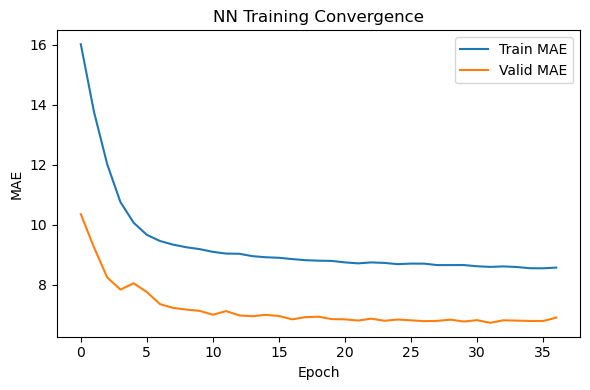

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history["train_mae"], label="Train MAE")
plt.plot(history["valid_mae"], label="Valid MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("NN Training Convergence")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Valid/Test ----
model.eval()
with torch.no_grad():
    # valid
    y_valid_pred_nn = []
    for x_num, x_cat, y in valid_loader:
        x_num = x_num.to(device)
        x_cat = x_cat.to(device)
        preds = model(x_num, x_cat)
        y_valid_pred_nn.append(preds.cpu().numpy())
    y_valid_pred_nn = np.vstack(y_valid_pred_nn).ravel()
    
    # test
    y_test_pred_nn = []
    for x_num, x_cat, y in test_loader:
        x_num = x_num.to(device)
        x_cat = x_cat.to(device)
        preds = model(x_num, x_cat)
        y_test_pred_nn.append(preds.cpu().numpy())
    y_test_pred_nn = np.vstack(y_test_pred_nn).ravel()

# ---- evaluation ----
eval_regression(y_valid, y_valid_pred_nn, "NeuralNet(Embedding+MLP) - Valid")
eval_regression(y_test,  y_test_pred_nn,  "NeuralNet(Embedding+MLP) - Test")



=== NeuralNet(Embedding+MLP) - Valid ===
MAE : 6.733
RMSE: 19.261
R²  : 0.691

=== NeuralNet(Embedding+MLP) - Test ===
MAE : 7.245
RMSE: 24.122
R²  : 0.570


(7.245240070129976, 24.12220555841719, 0.5704621235601718)